In [1]:
import numpy as np
import shutil
import os
import glob
import pandas as pd
import matplotlib.pylab as plt
import pickle
import sys
% matplotlib inline

from decimal import Decimal, ROUND_HALF_UP
from sklearn.model_selection import StratifiedKFold

# Root directory of the project
ROOT_DIR = os.path.abspath("../code")
# Import code
sys.path.append(ROOT_DIR)

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
from sklearn.preprocessing import LabelEncoder
from imblearn.metrics import classification_report_imbalanced
import itertools
from scipy import interp
from itertools import cycle, islice
from keras.utils import np_utils

# Some preprocessing utilities
from sklearn.utils import shuffle
from sklearn.manifold.t_sne import TSNE
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# The different classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix,balanced_accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc,roc_auc_score


from hierarchicalmodel import *
from preprocessing import *
from prediction import *
from optimisation import *
from utils import *

//anaconda/envs/tflearn/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.
//anaconda/envs/tflearn/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [3]:
# This Section Needs to be changed each time

nFeatures = 7 # Number of features considered

# All Labels of the different variabe stars
true_class_1=1;true_class_2=2;true_class_3=3;true_class_4=4;true_class_5=5;true_class_6=6;true_class_7=7;\
true_class_8=8;true_class_9=9;true_class_10=10;true_class_11=11;true_class_12=12;true_class_13=13

eclipsing_label = 20;rotational_label = 21;pulsating_label = 22;RR_Lyrae_label = 23; LPV_label = 24;\
delta_scuti_label = 25; cepheids_label   = 26

# The directory to save the files
plots_dir                 = '../results/hyperopt_hierarchical-results_rs/plots/'
results_dir               = '../results/hyperopt_hierarchical-results_rs/results/'
misclassify_dir           = r'../results/hyperopt_hierarchical-results_rs/results/Misclassification_'
dotfile_dir               = '../results/hyperopt_hierarchical-results_rs/Decision_tree_plots/'
savedir_decision_boundary ='../results/hyperopt_hierarchical-results_rs/decision_boundary_plots/'
features_dir              ='../results/hyperopt_hierarchical-results_rs/feature_analysis/'
lC_dir                    = '../data/catalogue/SSS_Per_Var_Cat/'


# Bayesian Optimisation

In [4]:
def objectives_xgb(space):
    classifier = XGBClassifier(objective = space['objective'],max_depth=space['max_depth'],eta = space['eta'],\
                               subsample = space['subsample'])

    classifier.fit(X_tr, y_tr)

    accuracies = cross_val_score(estimator=classifier, X=X_tr, y=y_tr, cv=StratifiedKFold(n_splits=nsplit),scoring='balanced_accuracy')
    CrossValMean = accuracies.mean()

    print("Accuracy {:.3f} params {}".format(CrossValMean, space))

    return{'loss':1-CrossValMean, 'status': STATUS_OK }

def objectives_rf(space):
    classifier = RandomForestClassifier(min_samples_split=space['min_samples_split'],n_estimators = space['n_estimators'],\
                                class_weight=space['class_weight'],max_features=space['max_features'])

    classifier.fit(X_tr, y_tr)

    accuracies = cross_val_score(estimator=classifier, X=X_tr, y=y_tr, cv=StratifiedKFold(n_splits=nsplit),scoring='balanced_accuracy')
    CrossValMean = accuracies.mean()

    print("Accuracy {:.3f} params {}".format(CrossValMean, space))

    return{'loss':1-CrossValMean, 'status': STATUS_OK }


def hyperparameter_optimization_xgb(multi=False):
    if multi:
        objective = 'multi:softmax'
    else:
        objective = 'binary:logistic'

    space ={'objective':objective,'max_depth':hp.choice('max_depth', np.arange(1,15,dtype=int)),\
                    'eta': hp.quniform ('eta', 0.0, 0.09, 0.01),'subsample': hp.quniform ('x_subsample', 0.4,0.8,0.1)}
    trials         = Trials()
    opt_parameters = fmin(fn=objectives_xgb,space=space,algo=tpe.suggest,max_evals=5,trials=trials)
    print(opt_parameters)

    best_params = space_eval(space, opt_parameters)
    print("BEST PARAMETERS: " + str(best_params))

    return best_params

def hyperparameter_optimization_rf(multi=False):
    class_weight = 'balanced'

    space ={'min_samples_split':hp.choice('min_samples_split', np.arange(2,20,dtype=int)),\
            'n_estimators': hp.choice('n_estimators', [50,150,250,350,450,550,650,750,850,950]),\
            'class_weight':hp.choice('class_weight', ['balanced']),\
            'max_features':hp.choice('max_features',['auto', 'sqrt', 'log2'])}


    trials         = Trials()
    opt_parameters = fmin(fn=objectives_rf,space=space,algo=tpe.suggest,max_evals=5,trials=trials)
    print(opt_parameters)

    best_params = space_eval(space, opt_parameters)
    print("BEST PARAMETERS: " + str(best_params))

    return best_params


# RF Classifier

In [5]:
def analysis_RF(X_train, y_train, types,save_model=False,multi=False):
    opt_parameters_RF = hyperparameter_optimization_rf(multi=multi)
    print(opt_parameters_RF)
    fit_model_RF = model_save(RandomForestClassifier(**opt_parameters_RF), X_train=X_train, y_train=y_train,\
                           filename_model= results_dir + types + '_RF_model.sav', save_model=save_model)
    return opt_parameters_RF, fit_model_RF

def final_prediction_RF(fitModel,X_train, y_train, X_test, y_test, testing_set,classes, types,nClasses,load_model=False):
    ypred, accuracy, MCC, conf_mat, misclassified  = model_fit(fitModel,filename_model= results_dir + types +'_RF_model.sav', X_train=X_train, y_train=y_train, X_test = X_test, y_test=y_test,\
                                                 classifier_model='RF Classifier',classes=classes, filename =results_dir + types +'_RF', load_model=load_model)
    misclassified_data, new_DF = find_misclassification(misclassified,y_test, test_data=testing_set,ypred=ypred, save_dir=results_dir + types +'Misclassification_RF.csv')

    plotting = plot(conf_mat, classes_types=classes, classifier_model='RF Classifier',\
                                  plot_title= plots_dir + types +'_RF', X_test=X_test, y_test=y_test, nClasses=nClasses,cmap=plt.cm.Blues)
    
    fpr,tpr,roc_auc=plot_ROC_curve(X_test, y_test, nClasses=nClasses, fit_model=fitModel,plots_dir=plots_dir+types,classes_types=classes)

    return ypred, accuracy, MCC, conf_mat, new_DF, misclassified,fpr,tpr,roc_auc


# XGBoost Classifier

In [6]:
def analysis_XGB(X_train, y_train, types,save_model=False,multi=False):
    opt_parameters_XGB = hyperparameter_optimization_xgb(multi=multi)
    print(opt_parameters_XGB)
    fit_model_XGB = model_save(XGBClassifier(**opt_parameters_XGB), X_train=X_train, y_train=y_train,\
                           filename_model= results_dir + types + '_XGB_model.sav', save_model=save_model)
    return opt_parameters_XGB, fit_model_XGB


def final_prediction_XGB(fitModel,X_train, y_train, X_test, y_test, testing_set,classes, types,nClasses,load_model=False):
    ypred, accuracy, MCC, conf_mat, misclassified  = model_fit(fitModel,filename_model= results_dir + types +'_XGB_model.sav', X_train=X_train, y_train=y_train, X_test = X_test, y_test=y_test,\
                                                 classifier_model='XGBoost Classifier',classes=classes, filename =results_dir + types +'_XGB', load_model=load_model)
    misclassified_data, new_DF = find_misclassification(misclassified,y_test, test_data=testing_set,ypred=ypred, save_dir=results_dir + types +'Misclassification_XGB.csv')

    plotting = plot(conf_mat, classes_types=classes, classifier_model='XGBoost Classifier',\
                                  plot_title= plots_dir + types +'_XGB', X_test=X_test, y_test=y_test, nClasses=nClasses,cmap=plt.cm.Blues)
    
    fpr,tpr,roc_auc=plot_ROC_curve(X_test, y_test, nClasses=nClasses, fit_model=fitModel,plots_dir=plots_dir+types,classes_types=classes)

    return ypred, accuracy, MCC, conf_mat, new_DF, misclassified,fpr,tpr,roc_auc


# Final Part:  CLASSIFICATION

## Hierarchical Classification Pipeline
- Split our whole dataset into 5 fold stratified splitting, that is, we have split our dataset into training set and test set. 

- Using the training set, we augment each layer depending on how much we want to augment the data in such a way that we have balanced classes. Augmentation is carried out by sampling from normal distribution assuming the mean of the gaussian to be the magnitude and the std to be the error on the magnitude, provided in the data.
- Using both the augmented data and the real data, we extract 6 features and then use the period from the ascii-catalogue to assign it to their respective class and for augmented data, we randomly sample from the true distribution of the true period. Therefore, we have 7 features that best describe each variable stars.
- For the test set, we have use only real example and features are extracted and true period from the ascii file is assigned to the respective class.
- The training and testing set features are saved in separate files such that for each iteration (in our case, there are 5 iterations), they are saved inseparate folders.
- For the classification, we then load the features, perform a normalisation and classification


### CLASSIFICATION

Accuracy 0.792 params {'eta': 0.03, 'subsample': 0.5, 'max_depth': 12, 'objective': 'multi:softmax'}
Accuracy 0.791 params {'eta': 0.06, 'subsample': 0.6000000000000001, 'max_depth': 10, 'objective': 'multi:softmax'}
Accuracy 0.770 params {'eta': 0.05, 'subsample': 0.7000000000000001, 'max_depth': 5, 'objective': 'multi:softmax'}
Accuracy 0.714 params {'eta': 0.09, 'subsample': 0.4, 'max_depth': 1, 'objective': 'multi:softmax'}
Accuracy 0.793 params {'eta': 0.03, 'subsample': 0.6000000000000001, 'max_depth': 14, 'objective': 'multi:softmax'}
{'x_subsample': 0.6000000000000001, 'eta': 0.03, 'max_depth': 13}
BEST PARAMETERS: {'eta': 0.03, 'subsample': 0.6000000000000001, 'max_depth': 14, 'objective': 'multi:softmax'}
{'eta': 0.03, 'subsample': 0.6000000000000001, 'max_depth': 14, 'objective': 'multi:softmax'}
Test set has shape (21242, 11)
Misclassified data has shape (5162, 11)
New test set has shape (16080, 11)
Normalized confusion matrix
[[0.73758824 0.16329412 0.09911765]
 [0.1796517

//anaconda/envs/tflearn/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda/envs/tflearn/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
//anaconda/envs/tflearn/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 576x432 with 0 Axes>

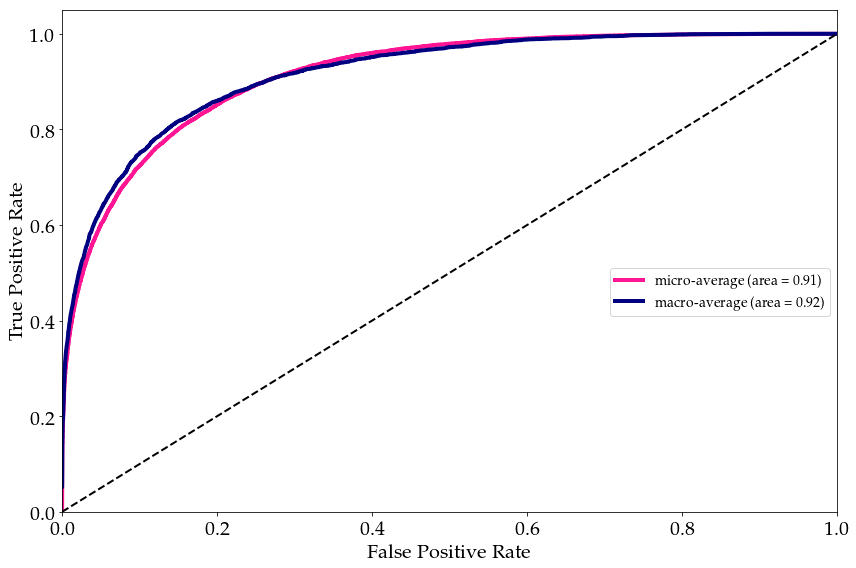

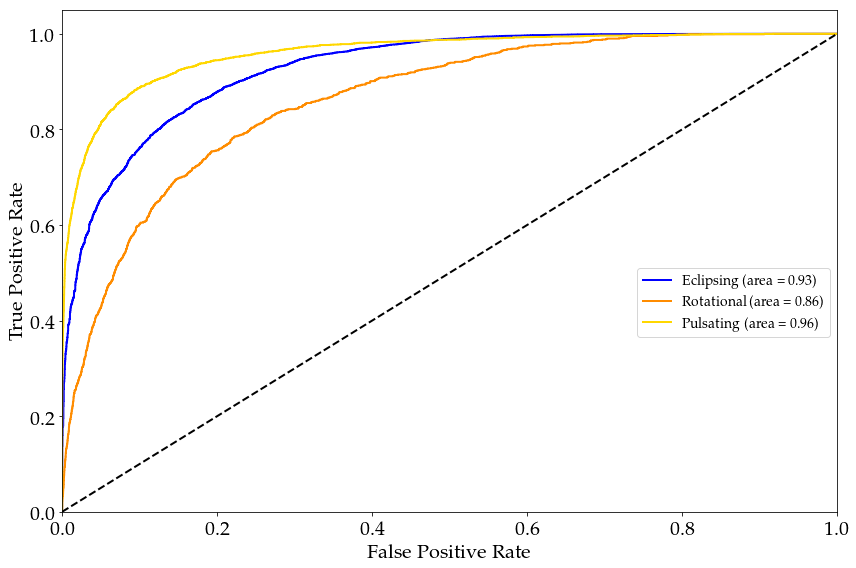

Accuracy 0.783 params {'max_features': 'log2', 'min_samples_split': 13, 'class_weight': 'balanced', 'n_estimators': 650}
Accuracy 0.784 params {'max_features': 'log2', 'min_samples_split': 10, 'class_weight': 'balanced', 'n_estimators': 150}
Accuracy 0.782 params {'max_features': 'auto', 'min_samples_split': 3, 'class_weight': 'balanced', 'n_estimators': 50}
Accuracy 0.784 params {'max_features': 'log2', 'min_samples_split': 8, 'class_weight': 'balanced', 'n_estimators': 250}
Accuracy 0.783 params {'max_features': 'log2', 'min_samples_split': 10, 'class_weight': 'balanced', 'n_estimators': 550}
{'max_features': 2, 'min_samples_split': 6, 'class_weight': 0, 'n_estimators': 2}
BEST PARAMETERS: {'max_features': 'log2', 'min_samples_split': 8, 'class_weight': 'balanced', 'n_estimators': 250}
{'max_features': 'log2', 'min_samples_split': 8, 'class_weight': 'balanced', 'n_estimators': 250}
Test set has shape (21242, 11)
Misclassified data has shape (5105, 11)
New test set has shape (16137, 1

<Figure size 576x432 with 0 Axes>

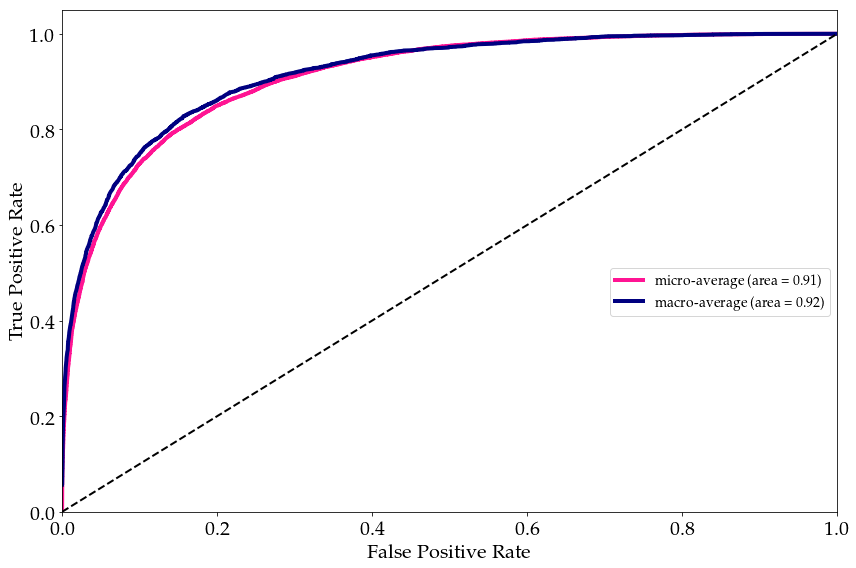

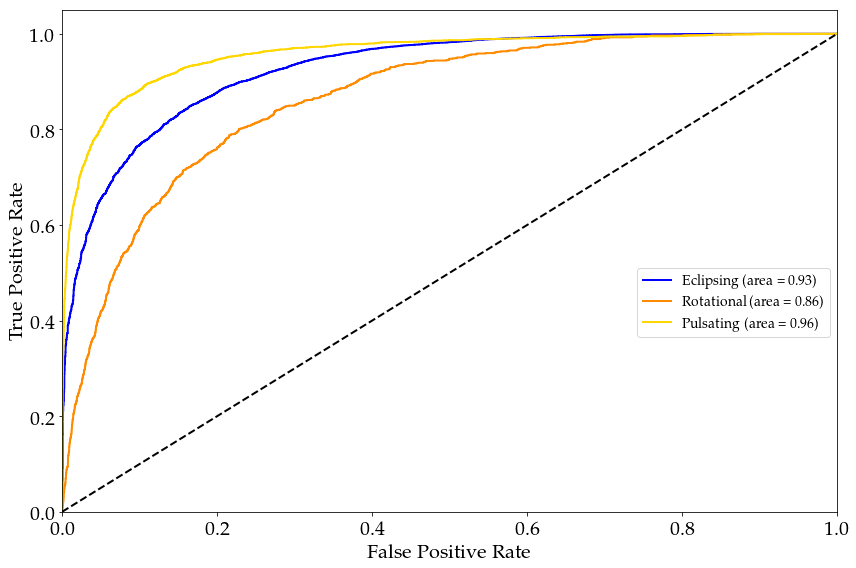

In [7]:
nsplit = 5
n_splits = 1
nFeatures = 7
multi_class  = True
save_model=False
load_model=False
acc_xgb_FL = [];mcc_xgb_FL = [];acc_rf_FL = [];mcc_rf_FL = [];\
acc_xgb_SL_EB = [];mcc_xgb_SL_EB = [];acc_rf_SL_EB = [];mcc_rf_SL_EB = [];\
acc_xgb_SL_RLCD = [];mcc_xgb_SL_RLCD = [];acc_rf_SL_RLCD = [];mcc_rf_SL_RLCD = [];\
acc_xgb_TL_RL = [];mcc_xgb_TL_RL = [];acc_rf_TL_RL = [];mcc_rf_TL_RL = [];\
acc_xgb_TL_Cep = [];mcc_xgb_TL_Cep = [];acc_rf_TL_Cep = [];mcc_rf_TL_Cep = []



for split_num in range(n_splits):
    split_num += 1
    
    '-----------------------------------------------------------------------------'
                                # FIRST LAYER
    '-----------------------------------------------------------------------------'
    num_examples_FL = 17000
    training_dir_FL      = '../data/rs/HC/layer1_EclRotPul/training_set/Split_'+str(split_num)+'/'
    testing_dir_FL       = '../data/rs/HC/layer1_EclRotPul/test_set/Split_'+str(split_num)+'/'
    all_training_set_FL  = pd.read_csv(training_dir_FL+'Training_features.csv',sep=',')
    all_testing_set_FL   = pd.read_csv(testing_dir_FL+'Test_features.csv',sep=',')
        
    eclipsing_class  = all_training_set_FL[all_training_set_FL.New_label==eclipsing_label].sample(n=num_examples_FL)
    rotational_class = all_training_set_FL[all_training_set_FL.New_label==rotational_label].sample(n=num_examples_FL)
    pulsating_class  = all_training_set_FL[all_training_set_FL.New_label==pulsating_label].sample(n=num_examples_FL)

    if multi_class:
        training_set_FL = pd.concat([eclipsing_class,rotational_class,pulsating_class], axis=0)   
        testing_set_FL = all_testing_set_FL
    else:
        training_set_FL = pd.concat([eclipsing_class,pulsating_class], axis=0) 
        testing_set_FL = all_testing_set_FL
    
    testing_data_FL = testing_set_FL
    
    # Performing normalisation
    X_train_FL, y_train_FL, filename_train_np_FL, X_test_FL, y_test_FL, filename_test_np_FL = normalisation(training_set_FL,testing_set_FL,label='New_label',nFeatures=nFeatures,normalisation=False)

    X_tr = X_train_FL; y_tr=y_train_FL
    
    
    if multi_class:
        classes_types_FL = ['Eclipsing','Rotational','Pulsating']
        types_FL         ='Type_FL_'+str(split_num)
        nClasses_FL      = len(classes_types_FL)
        
    else:
        classes_types_FL = ['Eclipsing','Rotational']
        types_FL         ='Type_Binary_Split_'+str(split_num)
        nClasses_FL      = 2

    # XGBoost Classifier   
    opt_xgb_FL, fit_model_xgb_FL = analysis_XGB(X_train_FL,y_train_FL, types_FL, save_model,multi=True) # This part can be commented when no training
    ypred_xgb_FL, accuracy_xgb_FL, MCC_xgb_FL, conf_mat_xgb_FL,new_DF_xgb_FL, misclassified_xgb_FL,fpr_xgb_FL,tpr_xgb_FL,roc_auc_xgb_FL  = final_prediction_XGB(fit_model_xgb_FL, X_train_FL, y_train_FL, X_test_FL, y_test_FL, testing_data_FL, classes_types_FL, types_FL, nClasses_FL, load_model)         


    opt_rf_FL, fit_model_rf_FL = analysis_RF(X_train_FL,y_train_FL, types_FL, save_model,multi=True) # This part can be commented when no training
    ypred_rf_FL, accuracy_rf_FL, MCC_rf_FL, conf_mat_rf_FL,new_DF_rf_FL, misclassified_rf_FL,fpr_rf_FL,tpr_rf_FL,roc_auc_rf_FL  = final_prediction_RF(fit_model_rf_FL, X_train_FL, y_train_FL, X_test_FL, y_test_FL, testing_data_FL, classes_types_FL, types_FL, nClasses_FL, load_model)         


    acc_xgb_FL.append(accuracy_xgb_FL)
    mcc_xgb_FL.append(MCC_xgb_FL)

    acc_rf_FL.append(accuracy_rf_FL)
    mcc_rf_FL.append(MCC_rf_FL)    


Accuracy 0.916 params {'eta': 0.04, 'subsample': 0.6000000000000001, 'max_depth': 10, 'objective': 'binary:logistic'}
Accuracy 0.917 params {'eta': 0.03, 'subsample': 0.7000000000000001, 'max_depth': 9, 'objective': 'binary:logistic'}
Accuracy 0.915 params {'eta': 0.02, 'subsample': 0.6000000000000001, 'max_depth': 7, 'objective': 'binary:logistic'}
Accuracy 0.913 params {'eta': 0.08, 'subsample': 0.5, 'max_depth': 11, 'objective': 'binary:logistic'}
Accuracy 0.901 params {'eta': 0.02, 'subsample': 0.5, 'max_depth': 1, 'objective': 'binary:logistic'}
{'x_subsample': 0.7000000000000001, 'eta': 0.03, 'max_depth': 8}
BEST PARAMETERS: {'eta': 0.03, 'subsample': 0.7000000000000001, 'max_depth': 9, 'objective': 'binary:logistic'}
{'eta': 0.03, 'subsample': 0.7000000000000001, 'max_depth': 9, 'objective': 'binary:logistic'}
Test set has shape (17000, 11)
Misclassified data has shape (1616, 11)
New test set has shape (15384, 11)
Normalized confusion matrix
[[0.9004282 0.0995718]
 [0.0428677 0.

<Figure size 576x432 with 0 Axes>

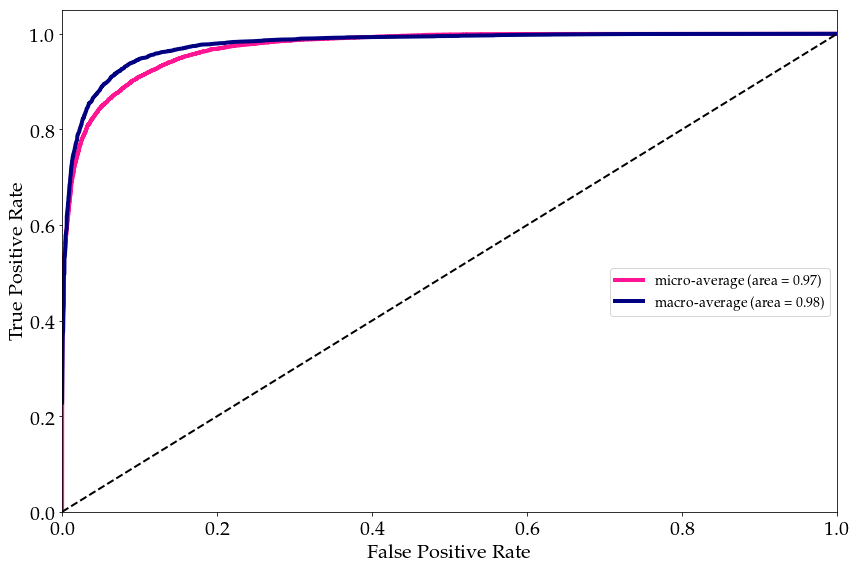

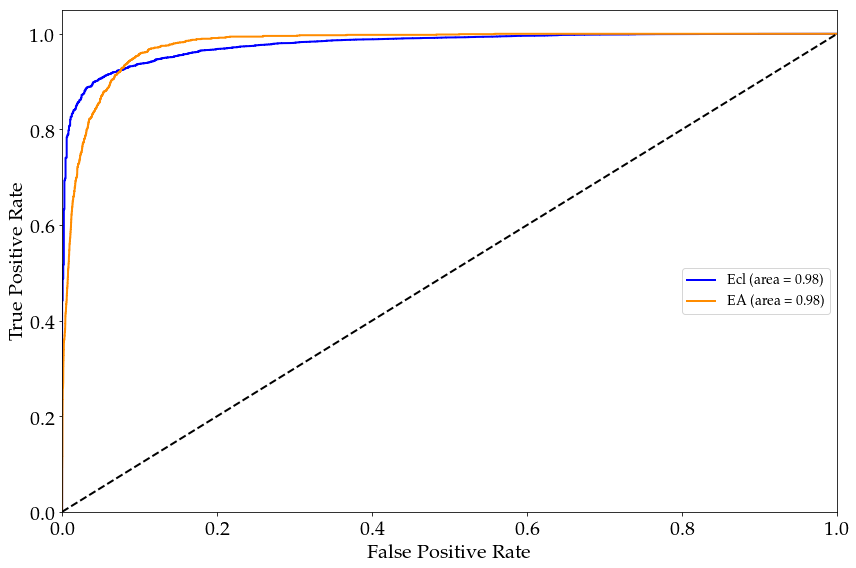

Accuracy 0.915 params {'max_features': 'log2', 'min_samples_split': 6, 'class_weight': 'balanced', 'n_estimators': 650}
Accuracy 0.916 params {'max_features': 'auto', 'min_samples_split': 3, 'class_weight': 'balanced', 'n_estimators': 450}
Accuracy 0.916 params {'max_features': 'auto', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 550}
Accuracy 0.914 params {'max_features': 'auto', 'min_samples_split': 10, 'class_weight': 'balanced', 'n_estimators': 450}
Accuracy 0.912 params {'max_features': 'log2', 'min_samples_split': 17, 'class_weight': 'balanced', 'n_estimators': 50}
{'max_features': 0, 'min_samples_split': 2, 'class_weight': 0, 'n_estimators': 5}
BEST PARAMETERS: {'max_features': 'auto', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 550}
{'max_features': 'auto', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 550}
Test set has shape (17000, 11)
Misclassified data has shape (1527, 11)
New test set has shape (15473, 11

<Figure size 576x432 with 0 Axes>

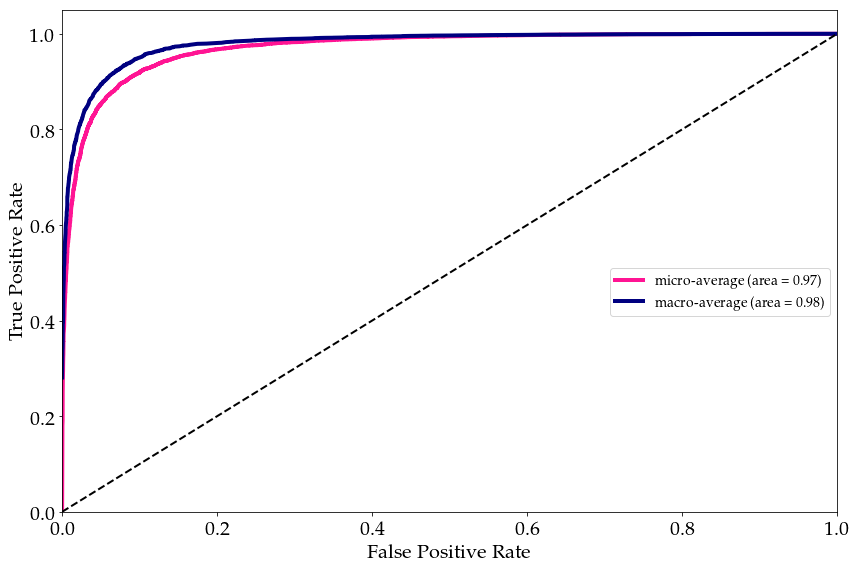

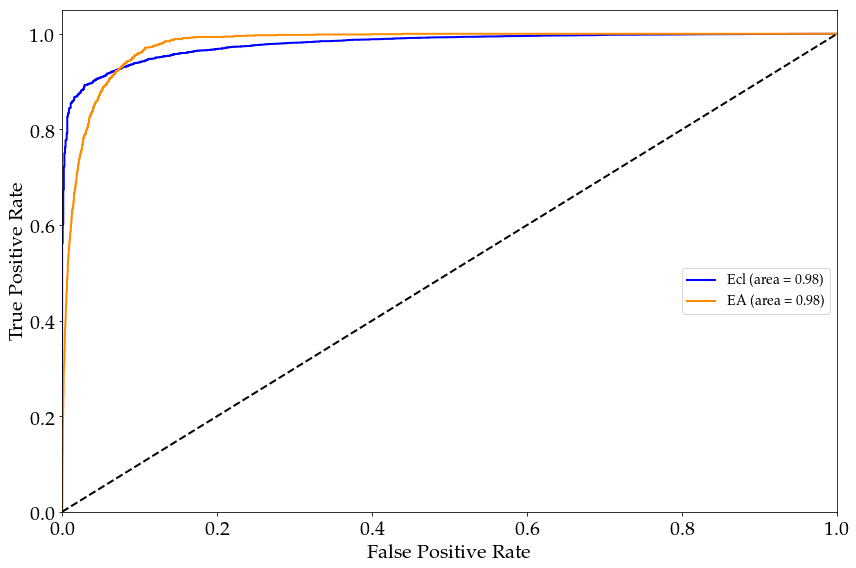

In [8]:
for split_num in range(n_splits):
    split_num += 1
    
    '-------------------------------------------------------------------------------'
                                # SECOND LAYER ECLIPSING BINARY
    '-------------------------------------------------------------------------------'
    num_examples_SL_EB     = 8000
    training_dir_SL_EB     = '../data/rs/HC/layer2_EB/training_set/Split_'+str(split_num)+'/'

    all_training_set_SL_EB = pd.read_csv(training_dir_SL_EB+'Training_features.csv',sep=',')
    all_testing_set_SL_EB = all_testing_set_FL#new_DF_xgb_FL
#     all_testing_set_SL_EB = new_DF_xgb_FL.drop(['New_label', 'Prediction'],axis=1)
    
    ecl_class  = all_training_set_SL_EB[all_training_set_SL_EB.New_label==true_class_5].sample(n=num_examples_SL_EB)
    EA_class   = all_training_set_SL_EB[all_training_set_SL_EB.New_label==true_class_6].sample(n=num_examples_SL_EB)
    
    ecl_class_test = all_testing_set_SL_EB[all_testing_set_SL_EB.True_class_labels==true_class_5]
    EA_class_test  = all_testing_set_SL_EB[all_testing_set_SL_EB.True_class_labels==true_class_6]

    training_set_SL_EB = pd.concat([ecl_class,EA_class], axis=0) 
    testing_set_SL_EB  = pd.concat([ecl_class_test,EA_class_test], axis=0)
        
    # Performing normalisation
    X_train_SL_EB, y_train_SL_EB, filename_train_np_SL_EB, X_test_SL_EB, y_test_SL_EB, filename_test_np_SL_EB = normalisation(training_set_SL_EB,testing_set_SL_EB,label='True_class_labels',nFeatures=nFeatures,normalisation=False)

    X_tr = X_train_SL_EB; y_tr=y_train_SL_EB

    
    classes_types_SL_EB = ['Ecl','EA']
    types_SL_EB         ='Type_SL_Ecl_EA_'+str(split_num)
    nClasses_SL_EB      = 2

    # XGBoost Classifier   
    opt_xgb_SL_EB, fit_model_xgb_SL_EB = analysis_XGB(X_train_SL_EB, y_train_SL_EB, types_SL_EB, save_model,multi=False) # This part can be commented when no training  
    ypred_xgb_SL_EB, accuracy_xgb_SL_EB, MCC_xgb_SL_EB, conf_mat_xgb_SL_EB,new_DF_xgb_SL_EB,misclassified_xgb_SL_EB,fpr_xgb_SL_EB,tpr_xgb_SL_EB,roc_auc_xgb_SL_EB = final_prediction_XGB(fit_model_xgb_SL_EB, X_train_SL_EB, y_train_SL_EB, X_test_SL_EB, y_test_SL_EB,testing_set_SL_EB, classes_types_SL_EB, types_SL_EB, nClasses_SL_EB, load_model) 

    opt_rf_SL_EB, fit_model_rf_SL_EB = analysis_RF(X_train_SL_EB, y_train_SL_EB, types_SL_EB, save_model,multi=False) # This part can be commented when no training  
    ypred_rf_SL_EB, accuracy_rf_SL_EB, MCC_rf_SL_EB, conf_mat_rf_SL_EB,new_DF_rf_SL_EB,misclassified_rf_SL_EB,fpr_rf_SL_EB,tpr_rf_SL_EB,roc_auc_rf_SL_EB = final_prediction_RF(fit_model_rf_SL_EB, X_train_SL_EB, y_train_SL_EB, X_test_SL_EB, y_test_SL_EB,testing_set_SL_EB, classes_types_SL_EB, types_SL_EB, nClasses_SL_EB, load_model) 


    acc_xgb_SL_EB.append(accuracy_xgb_SL_EB)
    mcc_xgb_SL_EB.append(MCC_xgb_SL_EB)

    acc_rf_SL_EB.append(accuracy_rf_SL_EB)
    mcc_rf_SL_EB.append(MCC_rf_SL_EB)

Accuracy 0.995 params {'eta': 0.07, 'subsample': 0.5, 'max_depth': 4, 'objective': 'multi:softmax'}
Accuracy 0.995 params {'eta': 0.05, 'subsample': 0.8, 'max_depth': 5, 'objective': 'multi:softmax'}
Accuracy 0.996 params {'eta': 0.08, 'subsample': 0.6000000000000001, 'max_depth': 8, 'objective': 'multi:softmax'}
Accuracy 0.995 params {'eta': 0.05, 'subsample': 0.6000000000000001, 'max_depth': 4, 'objective': 'multi:softmax'}
Accuracy 0.996 params {'eta': 0.04, 'subsample': 0.6000000000000001, 'max_depth': 6, 'objective': 'multi:softmax'}
{'x_subsample': 0.6000000000000001, 'eta': 0.08, 'max_depth': 7}
BEST PARAMETERS: {'eta': 0.08, 'subsample': 0.6000000000000001, 'max_depth': 8, 'objective': 'multi:softmax'}
{'eta': 0.08, 'subsample': 0.6000000000000001, 'max_depth': 8, 'objective': 'multi:softmax'}
Test set has shape (2792, 11)
Misclassified data has shape (23, 11)
New test set has shape (2769, 11)
Normalized confusion matrix
[[0.99439414 0.         0.         0.00560586]
 [0.      

<Figure size 576x432 with 0 Axes>

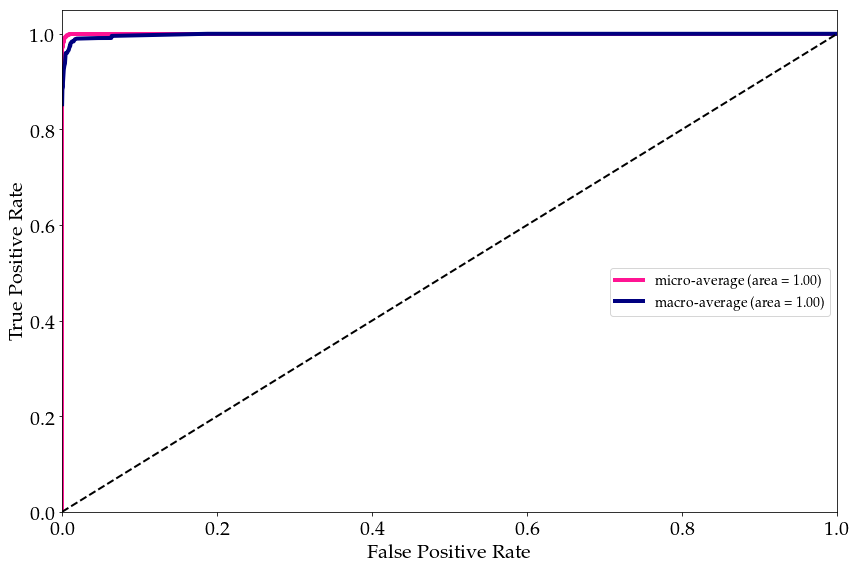

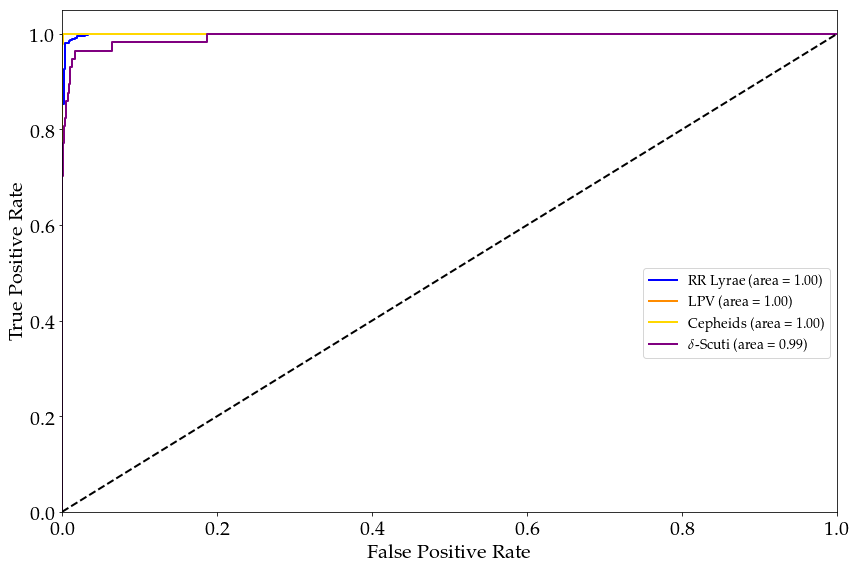

Accuracy 0.995 params {'max_features': 'auto', 'min_samples_split': 15, 'class_weight': 'balanced', 'n_estimators': 350}
Accuracy 0.995 params {'max_features': 'sqrt', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 550}
Accuracy 0.995 params {'max_features': 'auto', 'min_samples_split': 8, 'class_weight': 'balanced', 'n_estimators': 750}
Accuracy 0.995 params {'max_features': 'log2', 'min_samples_split': 10, 'class_weight': 'balanced', 'n_estimators': 450}
Accuracy 0.995 params {'max_features': 'log2', 'min_samples_split': 6, 'class_weight': 'balanced', 'n_estimators': 350}
{'max_features': 1, 'min_samples_split': 2, 'class_weight': 0, 'n_estimators': 5}
BEST PARAMETERS: {'max_features': 'sqrt', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 550}
{'max_features': 'sqrt', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 550}
Test set has shape (2792, 11)
Misclassified data has shape (23, 11)
New test set has shape (2769, 11)
N

<Figure size 576x432 with 0 Axes>

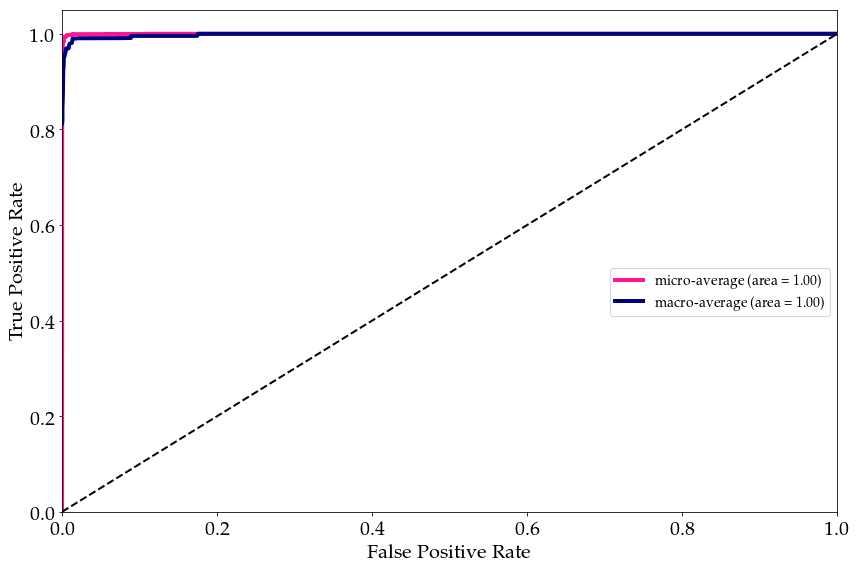

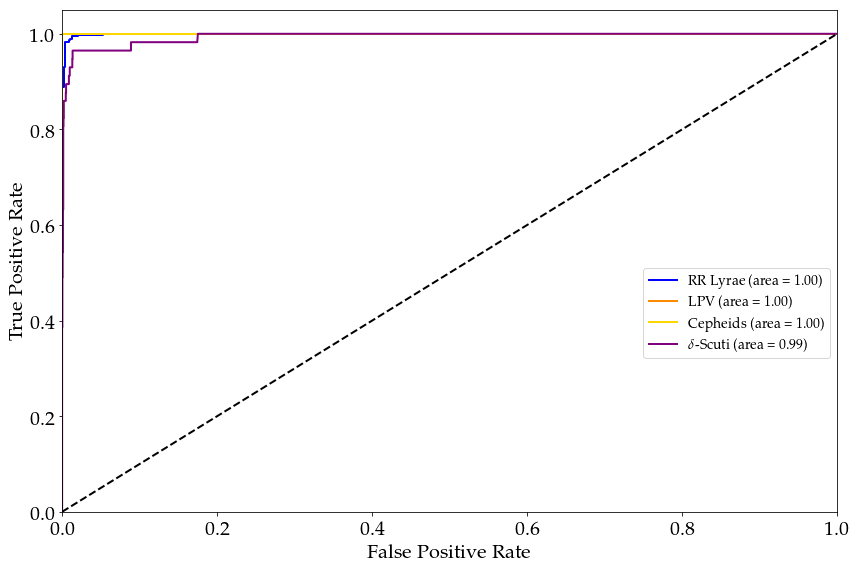

In [9]:
for split_num in range(n_splits):
    split_num += 1
    '-----------------------------------------------------------------------------'
                        # SECOND LAYER RR LYRAE PULSATING LPV CEPHEIDS
    '-----------------------------------------------------------------------------'
    num_examples_SL_RLCD     = 13900
    training_dir_SL_RLCD     = '../data/rs/HC/layer2_RLCD/training_set/Split_'+str(split_num)+'/'

    all_training_set_SL_RLCD = pd.read_csv(training_dir_SL_RLCD+'Training_features.csv',sep=',')
    all_testing_set_SL_RLCD  = all_testing_set_FL#new_DF_xgb_FL
        
    RR_Lyrae_class = all_training_set_SL_RLCD[all_training_set_SL_RLCD.New_label==RR_Lyrae_label].sample(n=num_examples_SL_RLCD)
    LPV_class      = all_training_set_SL_RLCD[all_training_set_SL_RLCD.New_label==LPV_label].sample(n=num_examples_SL_RLCD)
    Cep_class      = all_training_set_SL_RLCD[all_training_set_SL_RLCD.New_label==cepheids_label].sample(n=num_examples_SL_RLCD)
    ds_class       = all_training_set_SL_RLCD[all_training_set_SL_RLCD.New_label==delta_scuti_label].sample(n=num_examples_SL_RLCD)

    
    all_testing_set_SL_RLCD  = new_DF_xgb_FL.drop(['New_label', 'Prediction'],axis=1)
    RRab_test                = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_1]
    RRc_test                 = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_2]
    RRd_test                 = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_3]
    blazhko_test             = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_4]
    LPV_test                 = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_8]
    ACEP_test                = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_10]
    cep_ii_test              = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_12]
    delta_scuti_test         = all_testing_set_SL_RLCD[all_testing_set_SL_RLCD.True_class_labels==true_class_9]

    RR_Lyrae_test       = pd.concat([RRab_test,RRc_test,RRd_test,blazhko_test], axis=0)
    RR_Lyrae_test_class = np.full(len(RR_Lyrae_test), RR_Lyrae_label, dtype=int)


    LPV_test_class = np.full(len(LPV_test), LPV_label, dtype=int)

    cepheids_test       = pd.concat([ACEP_test, cep_ii_test] ,axis=0)
    cepheids_test_class = np.full(len(cepheids_test), cepheids_label, dtype=int)

    ds_test       = delta_scuti_test
    ds_test_class = np.full(len(ds_test), delta_scuti_label, dtype=int)

    second_layer_RLCD_test       = pd.concat([RR_Lyrae_test,LPV_test,cepheids_test,ds_test], axis=0)
    second_layer_RLCD_test_class = np.concatenate((RR_Lyrae_test_class,LPV_test_class,cepheids_test_class,ds_test_class), axis=0)
    testing_data_SL_RLCD         = pd.DataFrame(second_layer_RLCD_test)
    testing_data_SL_RLCD['New_label'] = second_layer_RLCD_test_class


    training_set_SL_RLCD = pd.concat([RR_Lyrae_class,LPV_class,Cep_class,ds_class], axis=0) 
    testing_set_SL_RLCD  = testing_data_SL_RLCD
        
    # Performing normalisation
    X_train_SL_RLCD, y_train_SL_RLCD, filename_train_np_SL_RLCD, X_test_SL_RLCD, y_test_SL_RLCD, filename_test_np_SL_RLCD = normalisation(training_set_SL_RLCD,testing_set_SL_RLCD, label='New_label',nFeatures=nFeatures, normalisation=False)

    X_tr = X_train_SL_RLCD; y_tr=y_train_SL_RLCD
   
    classes_types_SL_RLCD = ['RR Lyrae','LPV', 'Cepheids', '$\delta$-Scuti']
    types_SL_RLCD         ='Type_SL_RLCD_'+str(split_num)
    nClasses_SL_RLCD      = len(classes_types_SL_RLCD)

    opt_xgb_SL_RLCD, fit_model_xgb_SL_RLCD = analysis_XGB(X_train_SL_RLCD, y_train_SL_RLCD, types_SL_RLCD, save_model,multi=True) # This part can be commented if you don't want to train the algorithm  
    ypred_xgb_SL_RLCD, accuracy_xgb_SL_RLCD, MCC_xgb_SL_RLCD, conf_mat_xgb_SL_RLCD, new_DF_xgb_SL_RLCD,misclassified_xgb_SL_RLCD,fpr_xgb_SL_RLCD,tpr_xgb_SL_RLCD,roc_auc_xgb_SL_RLCD = final_prediction_XGB(fit_model_xgb_SL_RLCD,X_train_SL_RLCD, y_train_SL_RLCD, X_test_SL_RLCD, y_test_SL_RLCD,testing_set_SL_RLCD, classes_types_SL_RLCD, types_SL_RLCD, nClasses_SL_RLCD,load_model)

    opt_rf_SL_RLCD, fit_model_rf_SL_RLCD = analysis_RF(X_train_SL_RLCD, y_train_SL_RLCD, types_SL_RLCD, save_model,multi=True) # This part can be commented if you don't want to train the algorithm  
    ypred_rf_SL_RLCD, accuracy_rf_SL_RLCD, MCC_rf_SL_RLCD, conf_mat_rf_SL_RLCD, new_DF_rf_SL_RLCD,misclassified_rf_SL_RLCD,fpr_rf_SL_RLCD,tpr_rf_SL_RLCD,roc_auc_rf_SL_RLCD = final_prediction_RF(fit_model_rf_SL_RLCD,X_train_SL_RLCD, y_train_SL_RLCD, X_test_SL_RLCD, y_test_SL_RLCD,testing_set_SL_RLCD, classes_types_SL_RLCD, types_SL_RLCD, nClasses_SL_RLCD,load_model)


    acc_xgb_SL_RLCD.append(accuracy_xgb_SL_RLCD)
    mcc_xgb_SL_RLCD.append(MCC_xgb_SL_RLCD)

    acc_rf_SL_RLCD.append(accuracy_rf_SL_RLCD)
    mcc_rf_SL_RLCD.append(MCC_rf_SL_RLCD)


Accuracy 0.930 params {'eta': 0.06, 'subsample': 0.5, 'max_depth': 13, 'objective': 'multi:softmax'}
Accuracy 0.925 params {'eta': 0.02, 'subsample': 0.5, 'max_depth': 10, 'objective': 'multi:softmax'}
Accuracy 0.893 params {'eta': 0.09, 'subsample': 0.5, 'max_depth': 6, 'objective': 'multi:softmax'}
Accuracy 0.878 params {'eta': 0.04, 'subsample': 0.5, 'max_depth': 5, 'objective': 'multi:softmax'}
Accuracy 0.916 params {'eta': 0.07, 'subsample': 0.8, 'max_depth': 8, 'objective': 'multi:softmax'}
{'x_subsample': 0.5, 'eta': 0.06, 'max_depth': 12}
BEST PARAMETERS: {'eta': 0.06, 'subsample': 0.5, 'max_depth': 13, 'objective': 'multi:softmax'}
{'eta': 0.06, 'subsample': 0.5, 'max_depth': 13, 'objective': 'multi:softmax'}
Test set has shape (2628, 11)
Misclassified data has shape (232, 11)
New test set has shape (2396, 11)
Normalized confusion matrix
[[0.97074673 0.         0.00307929 0.02617398]
 [0.0026643  0.95293073 0.04440497 0.        ]
 [0.07284768 0.60927152 0.31788079 0.        ]


<Figure size 576x432 with 0 Axes>

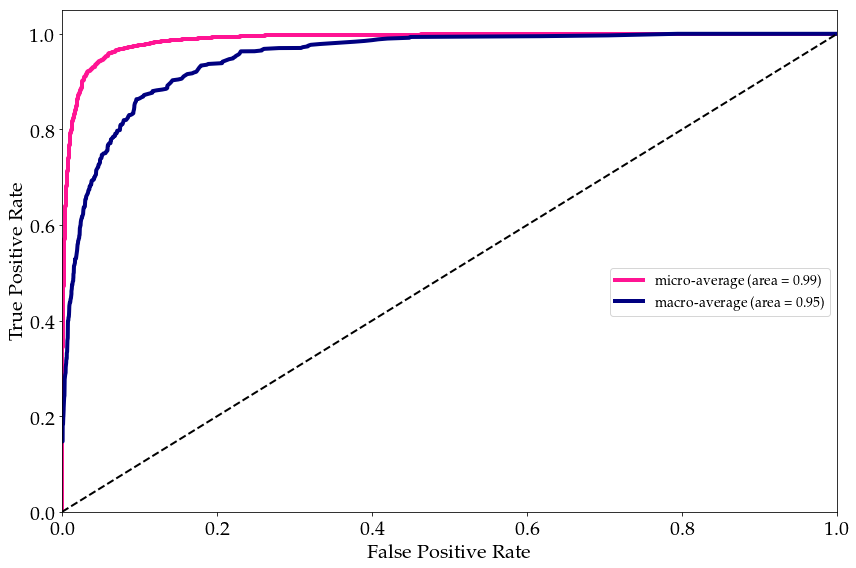

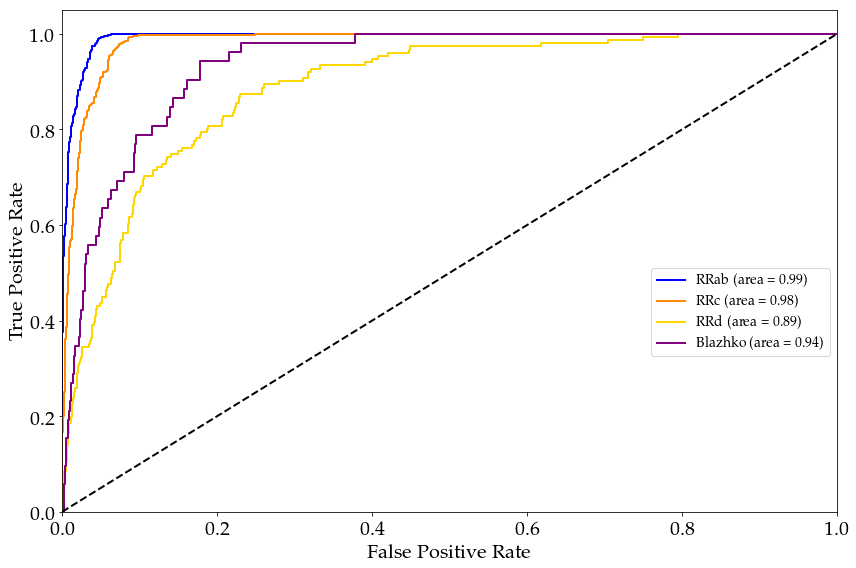

Accuracy 0.914 params {'max_features': 'log2', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 50}
Accuracy 0.907 params {'max_features': 'log2', 'min_samples_split': 18, 'class_weight': 'balanced', 'n_estimators': 750}
Accuracy 0.916 params {'max_features': 'sqrt', 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 350}
Accuracy 0.912 params {'max_features': 'auto', 'min_samples_split': 9, 'class_weight': 'balanced', 'n_estimators': 150}
Accuracy 0.914 params {'max_features': 'log2', 'min_samples_split': 6, 'class_weight': 'balanced', 'n_estimators': 50}
{'max_features': 1, 'min_samples_split': 0, 'class_weight': 0, 'n_estimators': 3}
BEST PARAMETERS: {'max_features': 'sqrt', 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 350}
{'max_features': 'sqrt', 'min_samples_split': 2, 'class_weight': 'balanced', 'n_estimators': 350}
Test set has shape (2628, 11)
Misclassified data has shape (228, 11)
New test set has shape (2400, 11)
Nor

<Figure size 576x432 with 0 Axes>

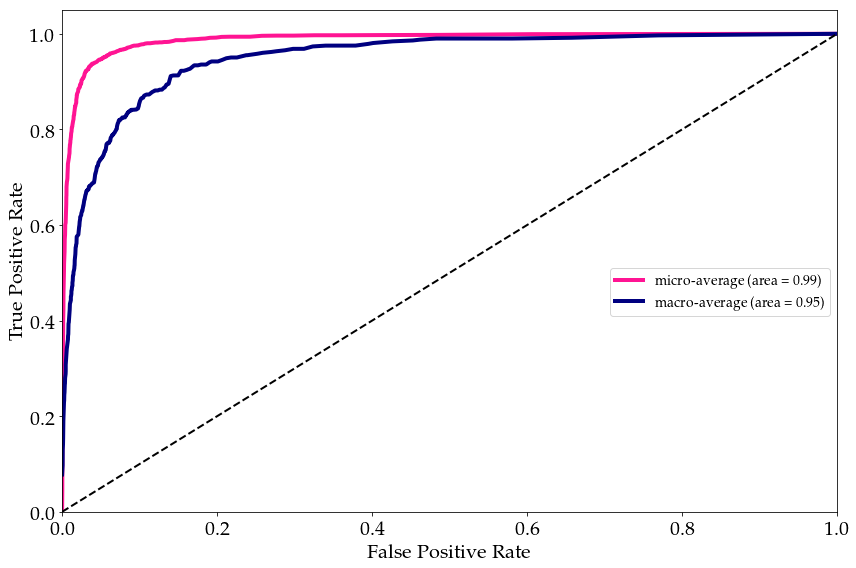

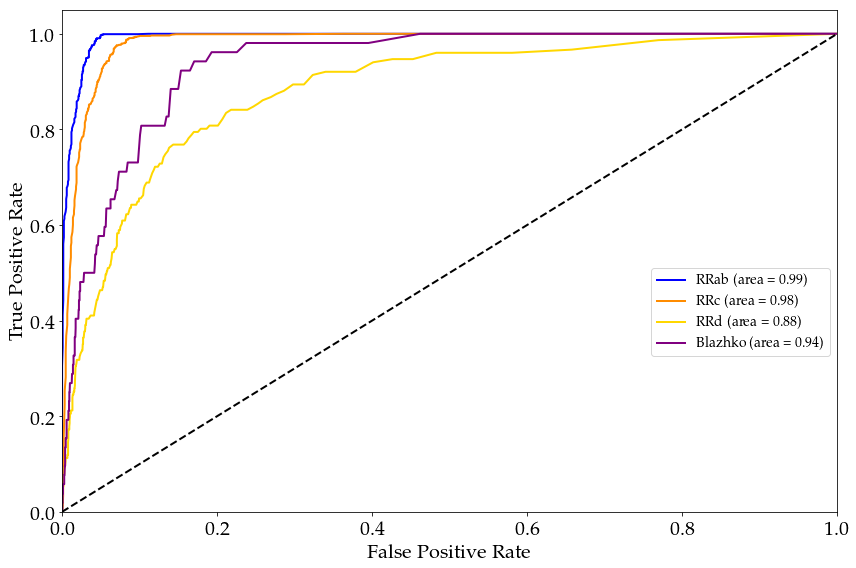

In [10]:
for split_num in range(n_splits):
    split_num += 1
    '-----------------------------------------------------------------------------'
                    # THIRD LAYER RR LYRAE: RRab, RRc, RRd, Blazhko
    '-----------------------------------------------------------------------------'
    num_examples_TL_RL     = 10000
    training_dir_TL_RL     = '../data/rs/HC/layer3_RRLyrae/training_set/Split_'+str(split_num)+'/'

    all_training_set_TL_RL = pd.read_csv(training_dir_TL_RL+'Training_features.csv',sep=',')
    all_testing_set_TL_RL  = all_testing_set_FL#new_DF_xgb_SL_RLCD.drop(["Prediction"],axis=1)
        
    RRab_class    = all_training_set_TL_RL[all_training_set_TL_RL.New_label==true_class_1].sample(n=num_examples_TL_RL)
    RRc_class     = all_training_set_TL_RL[all_training_set_TL_RL.New_label==true_class_2].sample(n=num_examples_TL_RL)
    RRd_class     = all_training_set_TL_RL[all_training_set_TL_RL.New_label==true_class_3].sample(n=num_examples_TL_RL)
    blazhko_class = all_training_set_TL_RL[all_training_set_TL_RL.New_label==true_class_4].sample(n=num_examples_TL_RL)

    RRab_class_test    = all_testing_set_TL_RL[all_testing_set_TL_RL.True_class_labels==true_class_1]
    RRc_class_test     = all_testing_set_TL_RL[all_testing_set_TL_RL.True_class_labels==true_class_2]
    RRd_class_test     = all_testing_set_TL_RL[all_testing_set_TL_RL.True_class_labels==true_class_3]
    blazhko_class_test = all_testing_set_TL_RL[all_testing_set_TL_RL.True_class_labels==true_class_4]

    
    training_set_TL_RL = pd.concat([RRab_class,RRc_class,RRd_class,blazhko_class], axis=0) 
    testing_set_TL_RL  = pd.concat([RRab_class_test,RRc_class_test,RRd_class_test,blazhko_class_test], axis=0)
        
    # Performing normalisation
    X_train_TL_RL, y_train_TL_RL, filename_train_np_TL_RL, X_test_TL_RL, y_test_TL_RL, filename_test_np_TL_RL = normalisation(training_set_TL_RL,testing_set_TL_RL, label='True_class_labels',nFeatures=nFeatures,normalisation=False)

    X_tr = X_train_TL_RL; y_tr=y_train_TL_RL

    
    # Random Forest Classifier    
    classes_types_TL_RL = ['RRab', 'RRc', 'RRd', "Blazhko"]
    types_TL_RL         ='Type_TL_RRLyrae_'+str(split_num)
    nClasses_TL_RL      = len(classes_types_TL_RL)

    # XGBoost Classifier   
    opt_xgb_TL_RL, fit_model_xgb_TL_RL = analysis_XGB(X_train_TL_RL, y_train_TL_RL, types_TL_RL, save_model,multi=True) # This part can be commented when no training 
    ypred_xgb_TL_RL, accuracy_xgb_TL_RL, MCC_xgb_TL_RL, conf_mat_xgb_TL_RL, new_DF_xgb_TL_RL, misclassified_xgb_TL_RL,fpr_xgb_TL_RL,tpr_xgb_TL_RL,roc_auc_xgb_TL_RL = final_prediction_XGB(fit_model_xgb_TL_RL, X_train_TL_RL, y_train_TL_RL, X_test_TL_RL, y_test_TL_RL,testing_set_TL_RL, classes_types_TL_RL, types_TL_RL, nClasses_TL_RL, load_model) 

    opt_rf_TL_RL, fit_model_rf_TL_RL = analysis_RF(X_train_TL_RL, y_train_TL_RL, types_TL_RL, save_model,multi=True) # This part can be commented when no training 
    ypred_rf_TL_RL, accuracy_rf_TL_RL, MCC_rf_TL_RL, conf_mat_rf_TL_RL, new_DF_rf_TL_RL, misclassified_rf_TL_RL,fpr_rf_TL_RL,tpr_rf_TL_RL,roc_auc_rf_TL_RL = final_prediction_RF(fit_model_rf_TL_RL, X_train_TL_RL, y_train_TL_RL, X_test_TL_RL, y_test_TL_RL,testing_set_TL_RL, classes_types_TL_RL, types_TL_RL, nClasses_TL_RL, load_model) 


    acc_xgb_TL_RL.append(accuracy_xgb_TL_RL)
    mcc_xgb_TL_RL.append(MCC_xgb_TL_RL)

    acc_rf_TL_RL.append(accuracy_rf_TL_RL)
    mcc_rf_TL_RL.append(MCC_rf_TL_RL)



Accuracy 0.995 params {'eta': 0.07, 'subsample': 0.5, 'max_depth': 7, 'objective': 'binary:logistic'}
Accuracy 0.995 params {'eta': 0.03, 'subsample': 0.8, 'max_depth': 7, 'objective': 'binary:logistic'}
Accuracy 0.967 params {'eta': 0.04, 'subsample': 0.4, 'max_depth': 3, 'objective': 'binary:logistic'}
Accuracy 0.995 params {'eta': 0.08, 'subsample': 0.5, 'max_depth': 6, 'objective': 'binary:logistic'}
Accuracy 0.987 params {'eta': 0.04, 'subsample': 0.7000000000000001, 'max_depth': 4, 'objective': 'binary:logistic'}
{'x_subsample': 0.8, 'eta': 0.03, 'max_depth': 6}
BEST PARAMETERS: {'eta': 0.03, 'subsample': 0.8, 'max_depth': 7, 'objective': 'binary:logistic'}
{'eta': 0.03, 'subsample': 0.8, 'max_depth': 7, 'objective': 'binary:logistic'}
Test set has shape (92, 11)
Misclassified data has shape (10, 11)
New test set has shape (82, 11)
Normalized confusion matrix
[[0.84782609 0.15217391]
 [0.06521739 0.93478261]]


<Figure size 576x432 with 0 Axes>

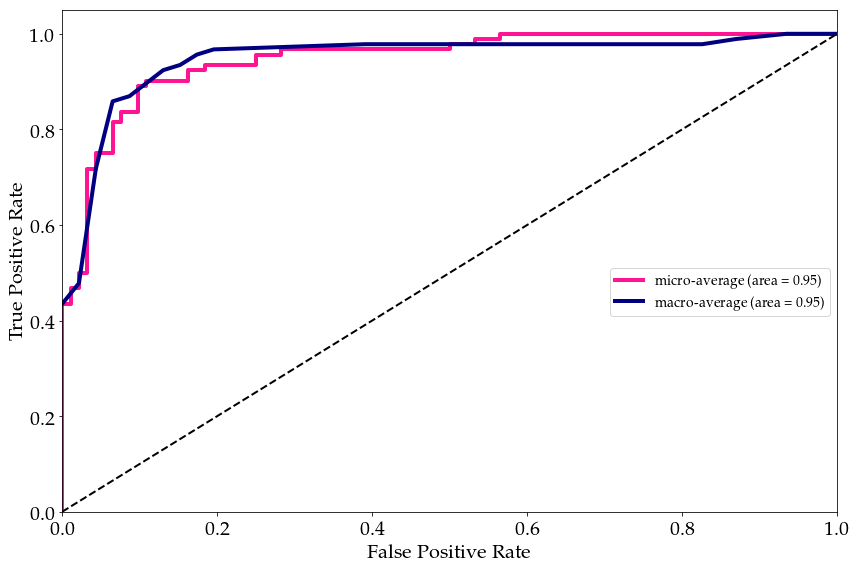

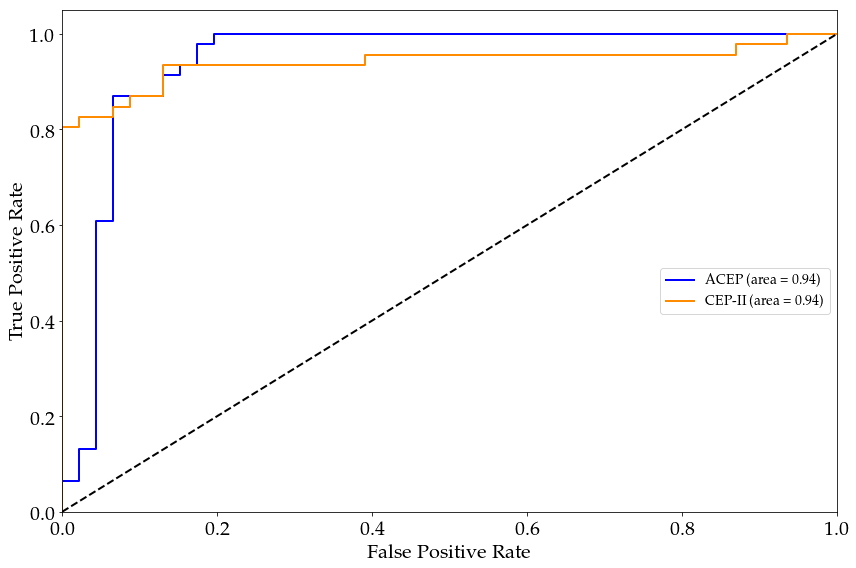

Accuracy 0.989 params {'max_features': 'auto', 'min_samples_split': 18, 'class_weight': 'balanced', 'n_estimators': 750}
Accuracy 0.989 params {'max_features': 'auto', 'min_samples_split': 18, 'class_weight': 'balanced', 'n_estimators': 550}
Accuracy 0.991 params {'max_features': 'log2', 'min_samples_split': 7, 'class_weight': 'balanced', 'n_estimators': 850}
Accuracy 0.992 params {'max_features': 'sqrt', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 250}
Accuracy 0.991 params {'max_features': 'log2', 'min_samples_split': 6, 'class_weight': 'balanced', 'n_estimators': 50}
{'max_features': 1, 'min_samples_split': 2, 'class_weight': 0, 'n_estimators': 2}
BEST PARAMETERS: {'max_features': 'sqrt', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 250}
{'max_features': 'sqrt', 'min_samples_split': 4, 'class_weight': 'balanced', 'n_estimators': 250}
Test set has shape (92, 11)
Misclassified data has shape (10, 11)
New test set has shape (82, 11)
Normal

<Figure size 576x432 with 0 Axes>

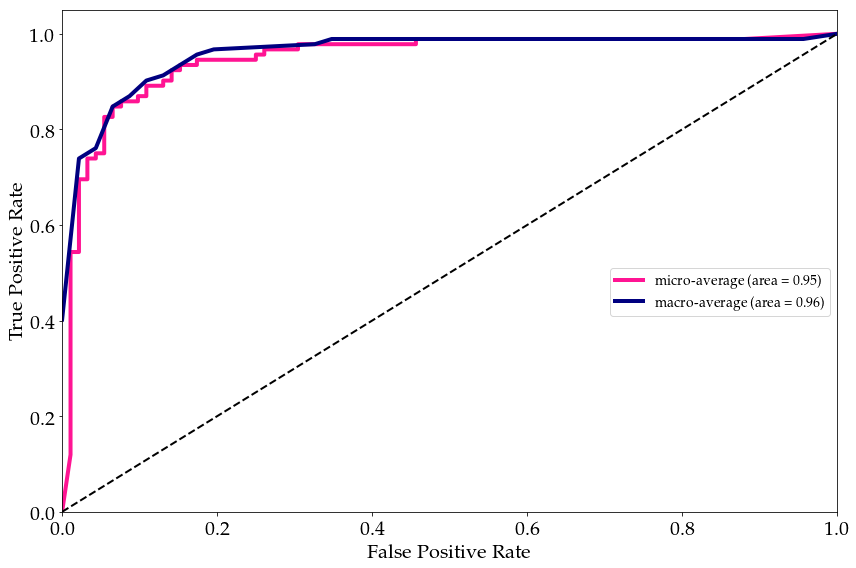

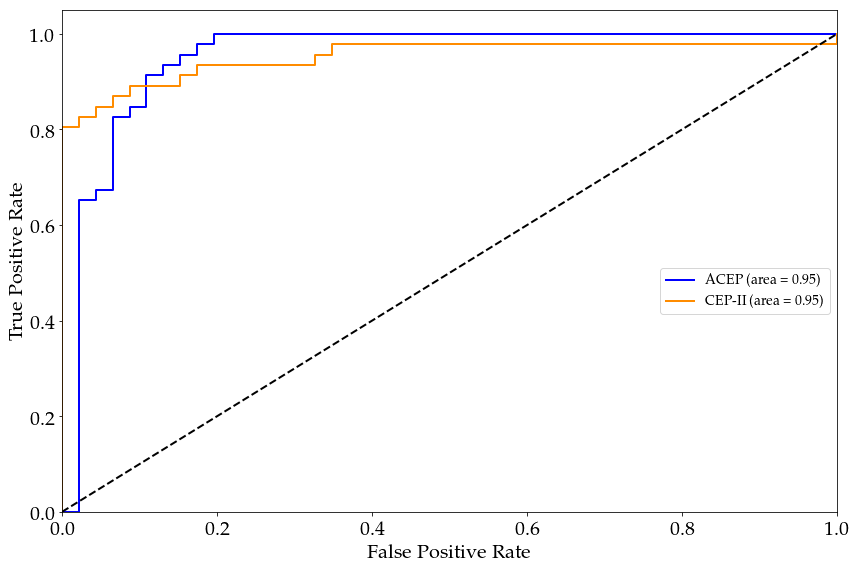

In [11]:
for split_num in range(n_splits):
    split_num += 1
    
    '-----------------------------------------------------------------------------'
                                # THIRD LAYER Cepheids: ACEP and Cep-II
    '-----------------------------------------------------------------------------'
    num_examples_TL_Cep     = 5000
    training_dir_TL_Cep     = '../data/rs/HC/layer3_Cepheids/training_set/Split_'+str(split_num)+'/'

    all_training_set_TL_Cep = pd.read_csv(training_dir_TL_Cep+'Training_features.csv',sep=',')
    all_testing_set_TL_Cep  = all_testing_set_FL#new_DF_xgb_SL_RLCD.drop(["Prediction"],axis=1)
        
    ACEP_class   = all_training_set_TL_Cep[all_training_set_TL_Cep.New_label==true_class_10].sample(n=num_examples_TL_Cep)
    Cep_ii_class = all_training_set_TL_Cep[all_training_set_TL_Cep.New_label==true_class_12].sample(n=num_examples_TL_Cep)

    ACEP_class_test   = all_testing_set_TL_Cep[all_testing_set_TL_Cep.True_class_labels==true_class_10]
    Cep_ii_class_test = all_testing_set_TL_Cep[all_testing_set_TL_Cep.True_class_labels==true_class_12]

    
    training_set_TL_Cep = pd.concat([ACEP_class,Cep_ii_class], axis=0) 
    testing_set_TL_Cep  = pd.concat([ACEP_class_test,Cep_ii_class_test], axis=0)
        
    # Performing normalisation
    X_train_TL_Cep, y_train_TL_Cep, filename_train_np_TL_Cep, X_test_TL_Cep, y_test_TL_Cep, filename_test_np_TL_Cep = normalisation(training_set_TL_Cep,testing_set_TL_Cep, label='True_class_labels',nFeatures=nFeatures,normalisation=False)

    X_tr = X_train_TL_Cep; y_tr=y_train_TL_Cep


    classes_types_TL_Cep = ['ACEP','CEP-II']
    types_TL_Cep         ='Type_TL_Cepheids_'+str(split_num)
    nClasses_TL_Cep      = 2

    # XGBoost Classifier   
    opt_xgb_TL_Cep, fit_model_xgb_TL_Cep = analysis_XGB(X_train_TL_Cep, y_train_TL_Cep, types_TL_Cep, save_model,multi=False) # This part can be commented when no training
    ypred_xgb_TL_Cep, accuracy_xgb_TL_Cep, MCC_xgb_TL_Cep, conf_mat_xgb_TL_Cep, new_DF_xgb_TL_Cep, misclassified_xgb_TL_Cep,fpr_xgb_TL_Cep,tpr_xgb_TL_Cep,roc_auc_xgb_TL_Cep = final_prediction_XGB(fit_model_xgb_TL_Cep, X_train_TL_Cep, y_train_TL_Cep, X_test_TL_Cep, y_test_TL_Cep, testing_set_TL_Cep, classes_types_TL_Cep, types_TL_Cep, nClasses_TL_Cep, load_model) 

    opt_rf_TL_Cep, fit_model_rf_TL_Cep = analysis_RF(X_train_TL_Cep, y_train_TL_Cep, types_TL_Cep, save_model,multi=False) # This part can be commented when no training
    ypred_rf_TL_Cep, accuracy_rf_TL_Cep, MCC_rf_TL_Cep, conf_mat_rf_TL_Cep, new_DF_rf_TL_Cep, misclassified_rf_TL_Cep,fpr_rf_TL_Cep,tpr_rf_TL_Cep,roc_auc_rf_TL_Cep = final_prediction_RF(fit_model_rf_TL_Cep, X_train_TL_Cep, y_train_TL_Cep, X_test_TL_Cep, y_test_TL_Cep, testing_set_TL_Cep, classes_types_TL_Cep, types_TL_Cep, nClasses_TL_Cep, load_model) 


    acc_xgb_TL_Cep.append(accuracy_xgb_TL_Cep)
    mcc_xgb_TL_Cep.append(MCC_xgb_TL_Cep)

    acc_rf_TL_Cep.append(accuracy_rf_TL_Cep)
    mcc_rf_TL_Cep.append(MCC_rf_TL_Cep)


In [12]:
metrics = open("../results/hyperopt_hierarchical-results_rs/metrics.txt", 'w')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_FL) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_FL)*100,np.std(acc_xgb_FL)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_FL)*100,np.std(mcc_xgb_FL)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_SL_EB) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_SL_EB)*100,np.std(acc_xgb_SL_EB)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_SL_EB)*100,np.std(mcc_xgb_SL_EB)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_SL_RLCD) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_SL_RLCD)*100,np.std(acc_xgb_SL_RLCD)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_SL_RLCD)*100,np.std(mcc_xgb_SL_RLCD)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_TL_RL) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_TL_RL)*100,np.std(acc_xgb_TL_RL)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_TL_RL)*100,np.std(mcc_xgb_TL_RL)) + '\n')

metrics.write('='*80+'\n')
metrics.write('***Testing Phase XGBoost for ' + str(classes_types_TL_Cep) + ' ***\n')
metrics.write('='*80+'\n')
metrics.write("Accuracy: ({} ± {}) %".format(np.mean(acc_xgb_TL_Cep)*100,np.std(acc_xgb_TL_Cep)) + '\n')
metrics.write("MCC: ({} ± {})".format(np.mean(mcc_xgb_TL_Cep)*100,np.std(mcc_xgb_TL_Cep)) + '\n')
metrics.close()
